-------- > epoch 1:  coût moyen entraînement = 0.6546251177787781
-------- > epoch 1:  taux moyen entraînement = 0.7698794007301331
-------- > epoch 1:  coût moyen validation = 0.4773857593536377
-------- > epoch 1:  taux moyen validation = 0.8297001719474792
-------- > epoch 2:  coût moyen entraînement = 0.4148024320602417
-------- > epoch 2:  taux moyen entraînement = 0.8533400893211365
-------- > epoch 2:  coût moyen validation = 0.38616329431533813
-------- > epoch 2:  taux moyen validation = 0.8648999929428101
-------- > epoch 3:  coût moyen entraînement = 0.36665090918540955
-------- > epoch 3:  taux moyen entraînement = 0.8697398900985718
-------- > epoch 3:  coût moyen validation = 0.36218756437301636
-------- > epoch 3:  taux moyen validation = 0.8746000528335571
-------- > epoch 4:  coût moyen entraînement = 0.3376122713088989
-------- > epoch 4:  taux moyen entraînement = 0.88092041015625
-------- > epoch 4:  coût moyen validation = 0.35456278920173645
-------- > epoch 4:  t

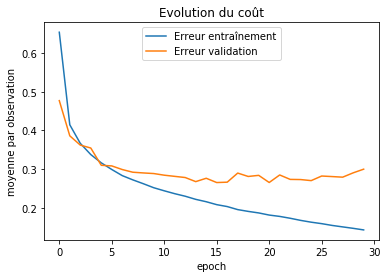

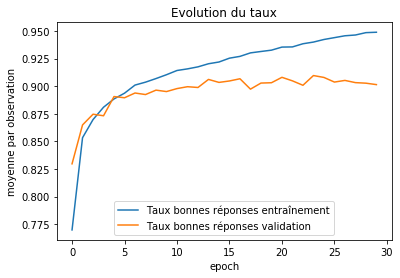

In [2]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exercice: FashionMNIST avec PyTorch
Exemple avec nn.Sequential et F.cross_entropy
Production de métriques avec graphes
Fonction entrainer
"""
import torch
torch.manual_seed(0) # Pour résultats reproductibles

# Fonction J d'entropie croisée
import torch.nn.functional as F
fonction_cout = F.cross_entropy

def taux_bonnes_predictions(lot_Y_predictions, lot_Y):
    predictions_categorie = torch.argmax(lot_Y_predictions, dim=1)
    return (predictions_categorie == lot_Y).float().mean()

from torch import nn
# Définition de l'architecture du RNA

modele = nn.Sequential(
    nn.Conv2d(1,32,3),
    nn.ReLU(),
    nn.Conv2d(32,16,3),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(24*24*16, 10)
)
    
from torch import optim
optimiseur = optim.SGD(modele.parameters(), lr=0.05)

import torchvision
import torchvision.transforms as transforms

#Chargement des données
ds = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
ds_ent, ds_valid = torch.utils.data.random_split(ds, [50000, 10000])
ds_test = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

#Création du DataLoader avec le dataset
dl_ent = torch.utils.data.DataLoader(ds_ent, batch_size=100, shuffle = True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=100)

def entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10):

    # Listes pour les métriques par epoch
    liste_cout_moyen_ent = []
    liste_taux_moyen_ent = []
    liste_cout_moyen_valid = []
    liste_taux_moyen_valid = []
    
    # Boucle d'apprentissage
    for epoch in range(nb_epochs):
        cout_total_ent = 0 # pour cumuler les couts par mini-lot
        taux_bonnes_predictions_ent = 0 # pour cumuler les taux par mini-lot
        modele.train() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        
        # Boucle d'apprentissage par mini-lot pour une epoch
        for lot_X, lot_Y in dl_ent:
            optimiseur.zero_grad() # Remettre les dérivées à zéro
            lot_Y_predictions = modele(lot_X) # Appel de la méthode forward
            cout = fonction_cout(lot_Y_predictions, lot_Y)
            cout.backward() # Calcul des gradiants par rétropropagation
            with torch.no_grad():
                cout_total_ent +=cout
                taux_bonnes_predictions_ent += taux_bonnes_predictions(lot_Y_predictions, lot_Y)
            optimiseur.step() # Mise à jour des paramètres
        # Calculer les moyennes par mini-lot
        with torch.no_grad():
            cout_moyen_ent = cout_total_ent/len(dl_ent)
            taux_moyen_ent = taux_bonnes_predictions_ent/len(dl_ent)
       
        modele.eval() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        with torch.no_grad():
            cout_valid = sum(fonction_cout(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
            taux_bons_valid = sum(taux_bonnes_predictions(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
        cout_moyen_valid = cout_valid/len(dl_valid)
        taux_moyen_valid = taux_bons_valid/len(dl_valid)
        print(f'-------- > epoch {epoch+1}:  coût moyen entraînement = {cout_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  taux moyen entraînement = {taux_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  coût moyen validation = {cout_moyen_valid}')
        print(f'-------- > epoch {epoch+1}:  taux moyen validation = {taux_moyen_valid}')
    
        liste_cout_moyen_ent.append(cout_moyen_ent)
        liste_taux_moyen_ent.append(taux_moyen_ent)
        liste_cout_moyen_valid.append(cout_moyen_valid)
        liste_taux_moyen_valid.append(taux_moyen_valid)
    
    # Affichage du graphique d'évolution des métriques par epoch
    import numpy as np
    import matplotlib.pyplot as plt
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_valid,label='Erreur validation')
    plt.title("Evolution du coût")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()
        
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_ent,label='Taux bonnes réponses entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_valid,label='Taux bonnes réponses validation')
    plt.title("Evolution du taux")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='lower center')
    plt.show()

entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=30)